In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import re
import math
import pickle


from itertools import product
from scipy.stats import entropy
from random import choices

## File reading of DNA of chromosomes

Downloaded from NCBI, as mentioned in the original article

In [2]:
def read_file(file_name):
  '''
  Read in FASTA file, return processed DNA sequence as string
  '''
  x = []

  for line in open(file_name):
    x.append(line.strip())

  metadata = x[0]
  dna = ''.join(x[1:])
  dna_clean = re.sub('[^CGAT]', '', dna)


  return dna_clean

In [5]:
# loading the file
file_to_read = 'NCBI_21chromosome.fa'#'NC_000001.11[11783684..11808140].fa'
seq = read_file(file_to_read)

## Finite Context Model

In [6]:
# base FCM

class FiniteContextModel:
    def __init__(self, M, delta=1):
        self.M = M # order of model
        self.delta = delta


        # mapping from nucleotide to integer
        self.seq_dict = {
            'A' : 0,
            'T' : 1,
            'C' : 2,
            'G' : 3
        }

        self.n = len(self.seq_dict.keys()) # size of vocabulary, always 4 for DNA
        
        '''# possible combinations of order M based on vocabulary
        combinations = [''.join(p) for p in product(self.seq_dict.keys(), repeat=self.M)]

        # initial count and probs, zero for every comb
        self.markov_freq = {comb : np.zeros(self.n) for comb in combinations}
        self.markov_prob = {comb : np.zeros(self.n) for comb in combinations}'''
        self.markov_freq = {}
        self.markov_prob = {}

        self.fitted = False

    def fit(self, seq):
        '''
          Fit the model aka learn statistics from the sequence. fill in frequencies of context and their probabilities
        
        '''

        for i in range(len(seq)-self.M):

            context = seq[i:i+self.M]
            next_nucleotide = self.seq_dict[seq[i+self.M]]

            # creates the key if it doesn't exist
            if context not in self.markov_freq:
                self.markov_freq[context] = np.zeros(self.n)

            # increase count in dict for taken context
            self.markov_freq[context][next_nucleotide] += 1

        for comb, count_array in self.markov_freq.items():

            # transform to probs

            total = np.sum(count_array)

            self.markov_prob[comb] = (count_array + self.delta)/(total + (self.n*self.delta))

        self.fitted = True

    def get_statistics(self):
        ''' 
          Returns probabilities of fitted model 

        '''

        if not self.fitted:
            raise Exception('Model is not fitted and probabilities are therefore equal.')

        return self.markov_prob

    def generate_seq(self, len_seq):
        '''
          Generates new sequence of length len_seq based on probabilities of fitted model
          
        '''

        if not self.fitted:
            raise Exception('Model is not fitted.')

        start = np.random.choice(list(self.seq_dict.keys()), self.M)

        context = ''.join(start)
        gen_seq = context

        while len(gen_seq) < len_seq:

            if context not in self.markov_freq:
                probs = [0.25, 0.25, 0.25, 0.25] # a: this
            else:
                probs = self.markov_prob[context]
            next_nucleotide = np.random.choice(list(self.seq_dict.keys()), p=probs)

            gen_seq = gen_seq + next_nucleotide

            context = gen_seq[-self.M:]

        return gen_seq

In [7]:
def pop_multiple_models(seq, max_order = 12, increment = 2, delta = 1, fitting = True):
    model_collection = {}
    model_name_array = []

    # loop that creates all models of orders M
    for M in range (2, max_order + 1, increment):
        key = 'fcm_' + str(M)

        value = FiniteContextModel(M, delta)
        if fitting:
            value.fit(seq)

        model_collection[key] = value
        model_name_array.append(key)

        # turns things into a list
        model_list = list(model_collection.values())

    return model_collection, model_name_array

In [ ]:
%%time

model_collection, model_name_array = pop_multiple_models(seq)

CPU times: user 6min 38s, sys: 6.42 s, total: 6min 44s
Wall time: 6min 42s


In [ ]:
# creating the list of models to feed into the stacked versions
model_list = list(model_collection.values())


# half version, for other sequences
half_model_name_array = model_name_array[1::2]

half_list = []
for key, value in model_collection.items():
    if key in half_model_name_array:
        half_list.append(value)

In [ ]:
half_model_name_array

['fcm_4', 'fcm_8', 'fcm_12']

## Meta Finite Context Model (getting competing models)

In [8]:
# this class takes advantage of multiple Finite Context Models - it takes into consideration all 
# the models in list and makes a choice of the best one during generation

class MetaFiniteContextModel:

  def __init__(self, model_list, model_name_array, block_size, word_size=5):
    self.model_list = model_list
    self.model_name_array = model_name_array
    self.block_size = block_size
    self.word_size = word_size


  def _calculate_bitrate(self, gen_seq):

    # that means process whole seq (used intentionnaly for seq D - cant be executed due to limited RAM)
    if self.word_size == 0:
      self.word_size = len(gen_seq)
    
    seq_blocks = [gen_seq[idx:idx + self.word_size] for idx in range(0, len(gen_seq), self.word_size)]

    # mapping from nucleotide to integer
    seq_dict = {
        'A' : 0,
        'T' : 1,
        'C' : 2,
        'G' : 3
    } 

    # possible combinations of order word_size based on vocabulary
    combinations = [''.join(p) for p in product(seq_dict.keys(), repeat=self.word_size)]

    seq_dist = [seq_blocks.count(comb)/len(gen_seq) for comb in combinations]


    return entropy(seq_dist, base=2)


  def _best_model_selector(self, block_size):
    ''' 
    Based on bitrate choose model from list 
    
    '''

    current_min_bitrate = 999
    current_best_sequence = ''

    # create block-sized sequences for all models
    for model in self.model_list:

        gen_seq = model.generate_seq(block_size)
        bitrate = self._calculate_bitrate(gen_seq)

        if bitrate < current_min_bitrate:

            current_min_bitrate = bitrate
            current_best_sequence = gen_seq
            model_index = self.model_list.index(model)

    return current_best_sequence, model_index, current_min_bitrate

  def generate_sequence(self, seq_length):
    ''' 
    Creating the full sequence based on the best competing model

    '''
    new_seq = ''

    total_blocks = math.ceil(seq_length/self.block_size)
    last_block_size = seq_length % self.block_size

    best_model_list = []
    information_content = []

    for i in range(total_blocks):

        if i == total_blocks - 1:
            competed_seq, best_index, gen_seq_bitrate = self._best_model_selector(last_block_size)
        else:
            competed_seq, best_index, gen_seq_bitrate = self._best_model_selector(self.block_size)
        
        new_seq += competed_seq

        best_model_list.append(self.model_name_array[best_index])
        information_content.append(gen_seq_bitrate)

    return new_seq, best_model_list, information_content

In [ ]:
single_model = MetaFiniteContextModel([model_collection['fcm_6']], ['fcm_6'], 100)
half_model = MetaFiniteContextModel(half_list, half_model_name_array, 100)
full_model = MetaFiniteContextModel(model_list, model_name_array, 100)

In [ ]:
half_seq, best_halfmodel_list, _ = half_model.generate_sequence(len(seq))

In [ ]:
new_seq, best_model_list, _ = full_model.generate_sequence(len(seq))

In [ ]:
single_seq, _, _ = single_model.generate_sequence(len(seq))

In [ ]:
random_seq = ''.join(choices(['C', 'G', 'A', 'T'], k=len(seq))) # as baseline 

In [ ]:
# save for ease of use later for evaluation
pickle.dump(half_seq, open( "half_seq.seq", "wb" ) )
pickle.dump(random_seq, open( "random_seq.seq", "wb" ))
pickle.dump(single_seq, open( "single_seq.seq", "wb" ))

# Evaluation

In [9]:
# calculates the two KL divergences of any two sequences
def kl_divergence(seq1, seq2, word_size=5):
    
    if len(seq1) != len(seq2):
        raise Exception('Both sequences must be of the same size')
    
    seq1_blocks = [seq1[idx:idx + word_size] for idx in range(0, len(seq1), word_size)]
    seq2_blocks = [seq2[idx:idx + word_size] for idx in range(0, len(seq2), word_size)]

    size = len(seq1_blocks)

    # mapping from nucleotide to integer
    seq_dict = {
        'A' : 0,
        'T' : 1,
        'C' : 2,
        'G' : 3
    }
    # possible combinations of order word_size based on vocabulary
    combinations = [''.join(p) for p in product(seq_dict.keys(), repeat=word_size)]
    
    seq1_dist = []
    seq2_dist = []

    for comb in combinations:
        seq1_dist.append(seq1_blocks.count(comb)/size)
        seq2_dist.append(seq2_blocks.count(comb)/size)

    divergence = entropy(seq1_dist, qk = seq2_dist, base=2)

    return divergence

In [ ]:
# pre-load generated sequences from code from above sections to evaluate

new_seq = pickle.load( open( 'new_seq.seq', 'rb') )
random_seq = pickle.load( open( 'random_seq.seq', 'rb') )
single_seq = pickle.load( open( 'single_seq.seq', 'rb') )
half_seq = pickle.load( open( 'half_seq.seq', 'rb') )

## Compare KL divergence between different models

In [ ]:
%%time
compare_all = kl_divergence(seq, new_seq, word_size = 5)
compare_half = kl_divergence(seq, half_seq, word_size = 5)
compare_single = kl_divergence(seq, single_seq, word_size = 5)
compare_random = kl_divergence(seq, random_seq, word_size = 5)

CPU times: user 23min 54s, sys: 12.9 s, total: 24min 6s
Wall time: 23min 52s


In [ ]:
comparison_complete = [compare_random, compare_single, compare_half, compare_all]

In [ ]:
print(comparison_complete)

[0.33241155832837177, 0.0025414146598010437, 0.008848265942491548, 0.008215183213789988]


## Compare KL divergence for different word sizes

In [ ]:
%%time
word_sizes = np.arange(2,7)

divergence_ws = [kl_divergence(seq, new_seq, word_size = w) for w in word_sizes]

CPU times: user 27min 30s, sys: 9 s, total: 27min 39s
Wall time: 27min 32s


In [ ]:
pd.DataFrame(dict(zip(word_sizes, divergence_ws)), index=['21 chromosome'])

,2,3,4,5,6
21 chromosome,0.001116,0.002309,0.004578,0.008215,0.017159


## Information content

In [10]:
# loading the file of 1 chromosome
file_to_read = 'NC_1chromosome.fa' 
seq1 = read_file(file_to_read)

In [11]:
# loading the file of Y chromosome
file_to_read = 'NCBI_Ychromosome.fa' 
seqY = read_file(file_to_read)

In [292]:
seq1 = seq1[:1000000] # get only first 1mil nucleotides as in paper
seqY = seqY[:22000000] # almost whole seq, in paper 22mil

In [294]:
len(seq1), len(seqY)

(1000000, 22000000)

In [ ]:
model_collection1, full_model_name_array = pop_multiple_models(seq1) # full set for seqC
model_collectionY, full_model_name_array = pop_multiple_models(seqY)

In [ ]:
full_model_list1 = list(model_collection1.values())
full_model_listY = list(model_collectionY.values())

In [ ]:
# for chromosome 1, with different number of competeing models (1,3,6 in our case), same SI (5)
modelA = MetaFiniteContextModel([model_collection1['fcm_6']], ['fcm_6'], 100)
modelB = MetaFiniteContextModel([model_collection1['fcm_4'], model_collection1['fcm_8'], model_collection1['fcm_12']], ['fcm_4', 'fcm_8''fcm_12'], 100)
modelC = MetaFiniteContextModel(full_model_list1, full_model_name_array, 100)


# for chromosme Y, with 8 competeing models, different SI (side information)
modelD = MetaFiniteContextModel(full_model_listY, full_model_name_array, 100, word_size=0)
modelE = MetaFiniteContextModel(full_model_listY, full_model_name_array, 100, word_size=1)
modelF = MetaFiniteContextModel(full_model_listY, full_model_name_array, 100, word_size=3)
modelG = MetaFiniteContextModel(full_model_listY, full_model_name_array, 100, word_size=5)

In [ ]:
seqA, seqA_best_models, seqA_information_content = modelA.generate_sequence(len(seq1))
seqB, seqB_best_models, seqB_information_content = modelB.generate_sequence(len(seq1))
seqC, seqC_best_models, seqC_information_content = modelC.generate_sequence(len(seq1))

/usr/local/lib/python3.7/dist-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [ ]:
# NOT ENOUGH RAM FOR THIS ONE
# seqD, seqD_best_models, seqD_information_content = modelD.generate_sequence(len(seqY)) 

seqE, seqE_best_models, seqE_information_content = modelE.generate_sequence(len(seqY))
seqF, seqF_best_models, seqF_information_content = modelF.generate_sequence(len(seqY))
seqG, seqG_best_models, seqG_information_content = modelG.generate_sequence(len(seqY))


/usr/local/lib/python3.7/dist-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [ ]:
# pickle.dump(seqA, open( "seqA.seq", "wb" ) )
# pickle.dump(seqB, open( "seqB.seq", "wb" ))
# pickle.dump(seqC, open( "seqC.seq", "wb" ))

# pickle.dump(seqA_information_content, open( "seqA_information_content.seq", "wb" ))
# pickle.dump(seqB_information_content, open( "seqB_information_content.seq", "wb" ))
# pickle.dump(seqC_information_content, open( "seqc_information_content.seq", "wb" ))

# pickle.dump(seqE_information_content, open( "seqE_information_content.seq", "wb" ))
# pickle.dump(seqE, open( "seqE.seq", "wb" ))
# pickle.dump(seqF_information_content, open( "seqF_information_content.seq", "wb" ))
# pickle.dump(seqF, open( "seqF.seq", "wb" ))
# pickle.dump(seqG_information_content, open( "seqG_information_content.seq", "wb" ))
# pickle.dump(seqG, open( "seqG.seq", "wb" ))

In [12]:
seqA_information_content = pickle.load( open( 'seqA_information_content.seq', 'rb') )
seqB_information_content = pickle.load( open( 'seqB_information_content.seq', 'rb') )
seqC_information_content = pickle.load( open( 'seqc_information_content.seq', 'rb') )

seqE_information_content = pickle.load( open( 'seqE_information_content.seq', 'rb') )
seqF_information_content = pickle.load( open( 'seqF_information_content.seq', 'rb') )
seqG_information_content = pickle.load( open( 'seqG_information_content.seq', 'rb') )

In [117]:
import scipy.signal as sc

# construct window lowpass filter (with blackman window)
filter = sc.firwin(21, 0.5, scale=True, window='blackman', pass_zero='lowpass')

In [149]:
# this was scaling manipulation, possible to obtain authors scale with some tuning, but imo not the way to go
# seqA_information_content_filtered = sc.filtfilt(filter, 1.4, seqA_information_content[:-1])
# seqB_information_content_filtered = sc.filtfilt(filter, 1.4, seqB_information_content[:-1])
# seqC_information_content_filtered = sc.filtfilt(filter, 1.4, seqC_information_content[:-1])

# seqE_information_content_filtered = sc.filtfilt(filter, 0.899, seqE_information_content[:-1])
# seqF_information_content_filtered = sc.filtfilt(filter, 1.4, seqF_information_content[:-1])
# seqG_information_content_filtered = sc.filtfilt(filter, 1.4, seqG_information_content[:-1])

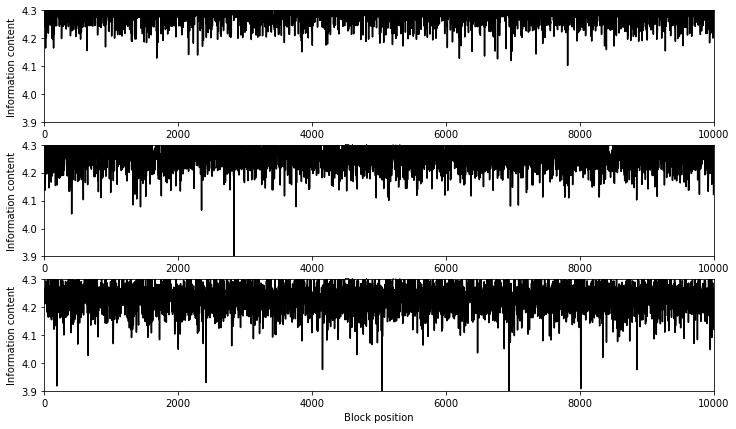

In [164]:
# filtfilt is backward-forward
# I omit the last one since default leads to 0, could use highpass filter so it looks nicer, but might as well omit it
seqA_information_content_filtered = sc.filtfilt(filter, 1, seqA_information_content[:-1])
seqB_information_content_filtered = sc.filtfilt(filter, 1, seqB_information_content[:-1])
seqC_information_content_filtered = sc.filtfilt(filter, 1, seqC_information_content[:-1])

fig, ax = plt.subplots(3, 1,figsize=(12,7))
ax[0].plot(seqA_information_content_filtered, color='black')
ax[1].plot(seqB_information_content_filtered, color='black')
ax[2].plot(seqC_information_content_filtered, color='black')

for a in ax:
  a.set_xlim([0, 10000])
  a.set_ylim([3.9, 4.3])
  a.set_xlabel('Block position')
  a.set_ylabel('Information content')

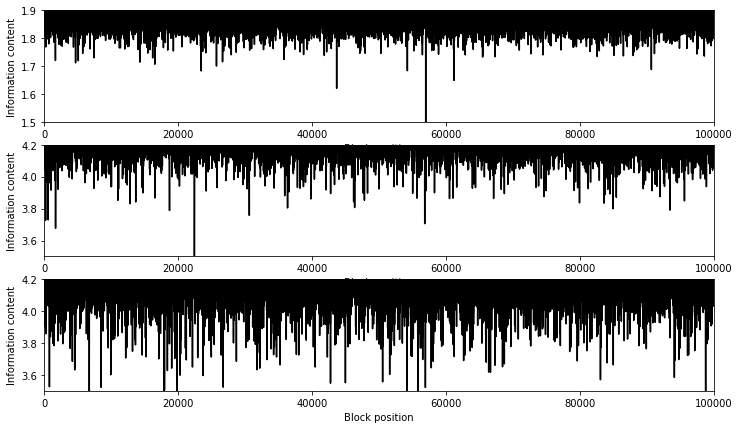

In [171]:
seqE_information_content_filtered = sc.filtfilt(filter, 1, seqE_information_content[:-1])
seqF_information_content_filtered = sc.filtfilt(filter, 1, seqF_information_content[:-1])
seqG_information_content_filtered = sc.filtfilt(filter, 1, seqG_information_content[:-1])

fig, ax = plt.subplots(3, 1,figsize=(12,7))
ax[0].plot(seqE_information_content_filtered, color='black')
ax[0].set_ylim([1.5, 1.9])
ax[1].plot(seqF_information_content_filtered, color='black')
ax[1].set_ylim([3.5, 4.2])
ax[2].plot(seqG_information_content_filtered, color='black')
ax[2].set_ylim([3.5, 4.2])

for a in ax:
  a.set_xlim([0, 100000])
  # a.set_ylim([1.5, 4.3])
  a.set_xlabel('Block position')
  a.set_ylabel('Information content')

## Machine Learning Test
Comparing the performance of this ML model (https://www.kaggle.com/code/singhakash/dna-sequencing-with-machine-learning/notebook) between the original and synthetically built datasets. Synthetically built dataset consists of one separate model for each class. ML model uses the exact same settings and evaluation is done with McNemar's Test

In [152]:
# loading the file
file_to_read = 'kaggle_human_dataset.txt'
kaggle_dna = pd.read_table(file_to_read)

In [154]:
kaggle_dna.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


Text(0.5, 1.0, 'Sequence class distribution')

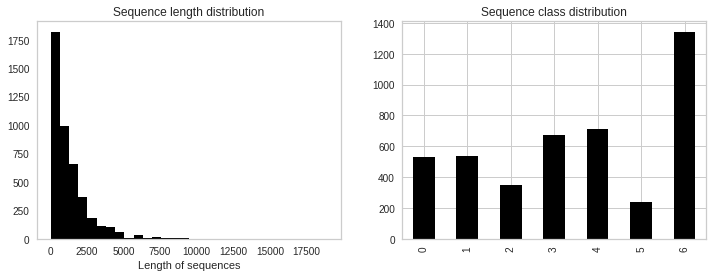

In [291]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

kaggle_dna['sequence'].apply(len).hist(bins=30, color='black', ax=ax[0])
ax[0].set_title("Sequence length distribution")
ax[0].set_xlabel('Length of sequences')
ax[0].grid(False)

kaggle_dna['class'].value_counts().sort_index().plot.bar(color='black', ax=ax[1])
plt.title("Sequence class distribution")


In [280]:
kaggle_dna.groupby('class')['sequence'].apply(lambda x: ''.join(x)).apply(len).astype(float)

class
0     829609.0
1     777626.0
2     642305.0
3     679350.0
4     623455.0
5     466647.0
6    1515570.0
Name: sequence, dtype: float64

In [195]:
def genseq_df(row):
    global kaggle_model_collection
    seq = kaggle_model_collection['model'+str(row['class'])].generate_seq(row['length'])
    return seq

kaggle_model_names = sorted(kaggle_dna['class'].unique())
kaggle_model_collection = {}


In [284]:
%%time
%%capture output 
# there is a warning regarding the entropy selection which has been suppressed with the capture output

# creation of synthetic data
def genseq_df(row):
    global kaggle_model_collection
    seq = kaggle_model_collection['model'+str(row['class'])].generate_seq(row['length'])
    return seq

kaggle_model_names = sorted(kaggle_dna['class'].unique())
kaggle_model_collection = {}

# first loop creates the relevant unfitted models
for name in kaggle_model_names:
    key = 'model'+str(name)
    
    current_collection, current_namelist = pop_multiple_models('', max_order = 6, increment = 1, fitting = False) 
    value = list(current_collection.values()) # puts in a list of unfitted models

    kaggle_model_collection[key] = value

# second loop fits the models based on the sequences provided
for index, row in kaggle_dna.iterrows():
    model_list = kaggle_model_collection['model'+str(row['class'])]

    for model in model_list:
        model.fit(row['sequence'])
    
    # puts the fitted models back into the model collection - not necessary as all models just live in memory and pointers point
    # kaggle_model_collection['model'+str(row['class'])] = model_list

# creates the combined models for each class
metamodel_collection = {}

for name in kaggle_model_names:
    key = 'model'+str(name)
    metamodel_collection[key] = MetaFiniteContextModel(kaggle_model_collection[key], current_namelist, 50, 4)

# third loop creates a synthetic dataframe with generated strings
synthetic_dna = kaggle_dna.copy()
synthetic_dna['length'] = synthetic_dna['sequence'].str.len()

# fourth loop creates a list of synthetic data to replace the original data, approx. 1000 per minute
new_sequences=[]
for index, row in synthetic_dna.iterrows():
    new_sequences.append(metamodel_collection['model'+str(row['class'])].generate_sequence(row['length']))
synthetic_dna['sequence'] = [item[0] for item in new_sequences]

synthetic_dna.drop('length', axis = 1)

CPU times: user 20min 18s, sys: 33.7 s, total: 20min 52s
Wall time: 20min 12s


In [285]:
synthetic_dna

,sequence,class,words,length
0,GGAATTAAAAGGCAGGGCCCCGGCAGAGCAGGCCGCACTACCCTGG...,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac...",207
1,TATGGCCCATCCTCCAACCGCGCAAAGACCAGATCCAATCATGCTG...,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa...",681
2,TACAGCTGAAGATCCAAGAGTAGCTTTGAGAAAAGGAGGTGCTGAA...,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca...",1686
3,AGCGTGGTTGTGGTCGATCAAAACCAGCTTGATTCTGGCCCCCTGC...,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca...",1206
4,TTTTTGTGGCCAATACTGGCATGGACAAGAACTGTGTGGAAACAGG...,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc...",1437
...,...,...,...,...
4375,GCCAAAACACACCCTTCCCTGTGGAGCGAACCAGTGGTACAGGCTC...,0,"[atggaa, tggaag, ggaaga, gaagat, aagatt, agatt...",57
4376,GCGCAAACCCCATCATCACACAGCTGAGGAAGAAGACAGCAAAGGG...,6,"[atgcag, tgcagt, gcagtc, cagtcc, agtcct, gtcct...",5883
4377,GCGGGCGGACATGGGAGACTTCCCCAGGTACAGAATGAATCCCGTG...,6,"[atgcag, tgcagt, gcagtc, cagtcc, agtcct, gtcct...",5817
4378,GACAACACCACCAAAGCACCTGGCAACCTCGGTGGAACCTCCATCA...,6,"[atgggg, tggggc, ggggca, gggcac, ggcacc, gcacc...",753


In [221]:
#  copy of kaggle work
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

def Kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

def kaggle_process(dna):
    dna['words'] = dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
    dna = dna.drop('sequence', axis=1)

    texts = list(dna['words'])
    for item in range(len(texts)):
        texts[item] = ' '.join(texts[item])
    #separate labels
    y = dna.iloc[:, 0].values # y_human for human_dna

    cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
    X = cv.fit_transform(texts)

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state=42)

    return X_train, X_test, y_train, y_test

In [235]:
# copy of kaggle work
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

def Kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

def kaggle_preprocess(dna):
    dna['words'] = dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
    dna = dna.drop('sequence', axis=1)

    texts = list(dna['words'])
    for item in range(len(texts)):
        texts[item] = ' '.join(texts[item])

    #separate labels
    y = dna.iloc[:, 0].values # y_human for human_dna

    return texts, y

def kaggle_process(dna, dna_syn):

    texts, y = kaggle_preprocess(dna)
    texts_syn, y_syn = kaggle_preprocess(dna_syn)


    cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
    X = cv.fit_transform(texts)
    X_syn = cv.transform(texts_syn)

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state=42)
    
    X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(X_syn, 
                                                    y_syn, 
                                                    test_size = 0.20, 
                                                    random_state=42)

    return X_train, X_test, y_train, y_test, X_test_syn, y_test_syn

In [286]:
X_train, X_test, y_train, y_test, X_test_syn, y_test_syn = kaggle_process(kaggle_dna, synthetic_dna)

In [287]:
# generating the models for both sets of data with identical settings as per Kaggle
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_syn = classifier.predict(X_test_syn)

In [210]:
# evaluation functions
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

In [250]:
# Confusion Matrix for Original Data
print("Confusion Matrix (Original Sequences)\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion Matrix (Original Sequences)

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984


In [289]:
# Confusion Matrix for Synthetic Data
print("Confusion Matrix (Synthetic Sequences)\n")
print(pd.crosstab(pd.Series(y_test_syn, name='Actual'), pd.Series(y_pred_syn, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_test_syn, y_pred_syn)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion Matrix (Synthetic Sequences)

Predicted   0  1   3   4  5    6
Actual                          
0          65  0   2   4  0   31
1          10  1   0  10  0   85
2           6  0   1   4  0   67
3          13  0  10  14  1   87
4          12  0   5  42  0   90
5          15  0   1   4  0   31
6           4  0   3   4  0  254
accuracy = 0.425 
precision = 0.453 
recall = 0.425 
f1 = 0.319


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [290]:
# McNemar's Test Comparing the Two Results

#clear eval directory and download script - reusing a script written for ML Ass 3
!rm -rf eval/
!git clone https://github.com/akrlowicz/eval/

from eval import ml3_evaluation_final

model_name_list = ['Original', 'Synthetic']
preds_array = [y_pred, y_pred_syn]

ml3_evaluation_final.multiple_mcnemar(model_name_list, preds_array, y_test, 0.01)


Cloning into 'eval'...
remote: Enumerating objects: 87, done.
remote: Total 87 (delta 0), reused 0 (delta 0), pack-reused 87
Unpacking objects: 100% (87/87), done.
-----Cochran's Q Test-----
Q-Score         478.2869
p-value         5.04e-106
Reject? (99%)      True


+----------+-----------+-------------------+-------------------------+---------+
| Model 1  |  Model 2  |        Chi²       |         p-Value         | Reject? |
+----------+-----------+-------------------+-------------------------+---------+
| Original | Synthetic | 476.3366533864542 | 1.3393251117203914e-105 |   True  |
+----------+-----------+-------------------+-------------------------+---------+


/usr/local/lib/python3.7/dist-packages/mlxtend/evaluate/cochrans_q.py:75: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  mod in y_model_predictions)).astype(int)
